# Yield (KS4)

author: laquitainesteeve@gmail.com

Validate yield from ks4

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM (GPU not needed)

Required resources:

- RAM: 184 GB

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download with notebooks/0_download_sortings.ipynb
4. Or Spike sort with: 
    - "_src/pipes/sorting/npx_vivo/10m/ks4.py_" 
    - "_src/pipes/sorting/npx_spont/10m/ks4.py_"
    - "_src/pipes/sorting/npx_evoked/10m/ks4.py_"
    - "_src/pipes/sorting/npx_synth/10m/ks4.py_"
    etc .. for denser probe

In [ ]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import spikeinterface as si
import matplotlib
import seaborn
from random import choices
from scipy import stats

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# spikebias package
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# SETUP EXPERIMENTS

# setup kilosort4 sorting paths
SORTED_PATH_nv = "dataset/01_intermediate/sorting/marques/SortingKS4_10m"
SORTED_PATH_ns = "dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m"
SORTED_PATH_ns_2X = "dataset/01_intermediate/sorting/npx_spont_2X/SortingKS4_10m"
SORTED_PATH_ne = "dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m"
SORTED_PATH_nb = "dataset/01_intermediate/sorting/buccino/SortingKS4_10m"

# setup kilosort4 sorting paths
SORTED_HV1 = "dataset/01_intermediate/sorting/horvath/probe_1/SortingKS4_10m"
SORTED_HV2 = "dataset/01_intermediate/sorting/horvath/probe_2/SortingKS4_10m"
SORTED_HV3 = "dataset/01_intermediate/sorting/horvath/probe_3/SortingKS4_10m"
SORTED_HS1 = "dataset/01_intermediate/sorting/dense_probe1/SortingKS4_10m"
SORTED_HS2 = "dataset/01_intermediate/sorting/dense_probe2/SortingKS4_10m"
SORTED_HS3 = "dataset/01_intermediate/sorting/dense_probe3/SortingKS4_10m"

# SETUP WAVEFORMS
MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-22 18:48:30,061 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-22 18:48:30,094 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-22 18:48:30,095 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-22 18:48:30,127 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-22 18:48:30,128 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-22 18:48:30,143 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-22 18:48:30,144 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-22 18:48:30,192 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-22 18:48:30,194 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-22 18:48:30,215 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-22 18:48:30,216 - root - utils.py - get_config 

## Get metadata

In [4]:
# get unit metadata
df_nv = fr.get_sorted_unit_meta(SORTED_PATH_nv)
df_ns = fr.get_sorted_unit_meta(SORTED_PATH_ns)
df_ns_2X = fr.get_sorted_unit_meta(SORTED_PATH_ns_2X)
df_ne = fr.get_sorted_unit_meta(SORTED_PATH_ne)
df_nb = fr.get_synth_unit_meta(SORTED_PATH_nb)

# keep units in cortex
df_nv = df_nv[np.isin(df_nv["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_ns = df_ns[np.isin(df_ns["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]
df_ns_2X = df_ns_2X[np.isin(df_ns_2X["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]
df_ne = df_ne[np.isin(df_ne["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]

# standardize layer 2/3
df_ns["layer"][(df_ns["layer"] == "L2") | (df_ns["layer"] == "L3")] = "L2/3"
df_ns_2X["layer"][(df_ns_2X["layer"] == "L2") | (df_ns_2X["layer"] == "L3")] = "L2/3"
df_ne["layer"][(df_ne["layer"] == "L2") | (df_ne["layer"] == "L3")] = "L2/3"

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_ns["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_ns_2X["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

## Plot isolation quality NPX

In [5]:
df_nv

,layer,firing_rate,kslabel,amplitude
51,L6,5.9716668128967285,mua,9.3
151,L6,21.28333282470703,good,8.1
152,L6,6.199999809265137,good,7.5
157,L6,3.4683332443237305,good,9.0
160,L6,1.1549999713897705,good,8.8
...,...,...,...,...
351,L6,0.0833333358168602,mua,8.5
352,L6,2.1033332347869873,good,9.1
353,L6,16.15166664123535,good,7.6
354,L6,2.3983333110809326,mua,8.7


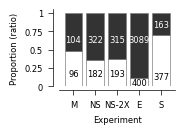

In [6]:
# setup
FIGSIZE = (1.5, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
isolation.plot_unit_isolation(ax, df_nv, df_ns, df_ns_2X, df_ne, df_nb, legend_cfg)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
plt.savefig(
    "figures/1_sorting_quality/yield/assets/fig5A_npx_unit_isolation.svg",
    **savefig_cfg,
)

In [7]:
# number of single-units
good_m = sum(df_nv["kslabel"] == "good")
good_ns = sum(df_ns["kslabel"] == "good")
good_ns2x = sum(df_ns_2X["kslabel"] == "good")
good_e = sum(df_ne["kslabel"] == "good")
good_s = sum(df_nb["kslabel"] == "good")

# number of total sorted units
total_m = len(df_nv["kslabel"])
total_ns = len(df_ns["kslabel"])
total_ns2x = len(df_ns_2X["kslabel"])
total_e = len(df_ne["kslabel"])
total_s = len(df_nb["kslabel"])

good_npx = np.array([good_m, good_ns, good_ns2x, good_e, good_s])
total_npx = np.array([total_m, total_ns, total_ns2x, total_e, total_s])

### Hyp. Testing: the proportion of single-units is the same across experiments

#### Spontaneous regimes

In [31]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[:3]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[:3] / total_npx[:3] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[:3] / total_npx[:3] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[:3])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 41.0 %
\chi^2 (2, 1212)=2.0, p=0.3666237758281437


#### Spontaneous vs. evoked

In [38]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[1, 3]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[1, 3]] / total_npx[[1, 3]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[1, 3]] / total_npx[[1, 3]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[1, 3]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 24.0 %
\chi^2 (1, 3993)=12.8, p=0.0003525852052219466


#### Synthetic vs. vivo

In [40]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[0, 4]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[0, 4]] / total_npx[[0, 4]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[0, 4]] / total_npx[[0, 4]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[0,4]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 59.0 %
\chi^2 (1, 740)=4.0, p=0.04445298002456542


## Isolation dense probe

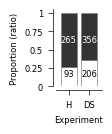

In [9]:
# get metadata
df_hv1 = fr.get_sorted_unit_meta(SORTED_HV1)
df_hv2 = fr.get_sorted_unit_meta(SORTED_HV2)
df_hv3 = fr.get_sorted_unit_meta(SORTED_HV3)
df_hs1 = fr.get_sorted_unit_meta(SORTED_HS1)
df_hs2 = fr.get_sorted_unit_meta(SORTED_HS2)
df_hs3 = fr.get_sorted_unit_meta(SORTED_HS3)

# keep units in cortex
df_hv1 = df_hv1[np.isin(df_hv1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv2 = df_hv2[np.isin(df_hv2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv3 = df_hv3[np.isin(df_hv3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs1 = df_hs1[np.isin(df_hs1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs2 = df_hs2[np.isin(df_hs2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs3 = df_hs3[np.isin(df_hs3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_hv1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

assert all(
    np.isin(np.sort(df_hs1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

# setup
FIGSIZE = (0.6, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
ax = isolation.plot_unit_isolation_dense_probe(
    ax, df_hv1, df_hv2, df_hv3, df_hs1, df_hs2, df_hs3
)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
plt.savefig(
    "figures/1_sorting_quality/yield/assets/fig5B_dense_unit_isolation.svg",
    **savefig_cfg,
)

### Hyp. Testing: the proportion of single-units is the same across experiments

In [24]:
good_hv1 = sum(df_hv1["kslabel"] == "good")
good_hv2 = sum(df_hv2["kslabel"] == "good")
good_hv3 = sum(df_hv3["kslabel"] == "good")
good_h = good_hv1 + good_hv2 + good_hv3
total_h = len(df_hv1["kslabel"]) + len(df_hv2["kslabel"]) + len(df_hv3["kslabel"])

good_hs1 = sum(df_hs1["kslabel"] == "good")
good_hs2 = sum(df_hs2["kslabel"] == "good")
good_hs3 = sum(df_hs3["kslabel"] == "good")

good_ds = good_hs1 + good_hs2 + good_hs3
total_ds = len(df_hs1["kslabel"]) + len(df_hs2["kslabel"]) + len(df_hs3["kslabel"])

good_dense = np.array([good_h, good_ds])
total_dense = np.array([total_h, total_ds])

array([ 93, 206])

In [26]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_dense) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_dense / total_dense * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:", np.round(np.mean(good_dense / total_dense * 100)), "%"
)
print(
    f"\chi^2 ({dof}, {sum(total_dense)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 31.0 %
\chi^2 (1, 920)=1.8, p=0.17729337530535055


### Hyp. testing: single-unit ratio is the same between probe

* we compared the average ratios of (M,NS) and (H, DS)

In [47]:
good_probes_v = np.array([good_npx[0], good_dense[0]])
total_probes_v = np.array([total_npx[0], total_dense[0]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_v) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_v / total_probes_v * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_v / total_probes_v * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_probes_v)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 37.0 %
\chi^2 (1, 558)=6.6, p=0.010454200240941174


In [56]:
good_probes_s = np.array([good_npx[1], good_dense[1]])
total_probes_s = np.array([total_npx[1], total_dense[1]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_s) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_s / total_probes_s * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_s / total_probes_s * 100)),
    "%",
)
print(f"\chi^2 ({dof}, {sum(total_probes_s)})={result.statistic}, p={result.pvalue}")


dense:
expected sorting accuracy: 36.0 %
\chi^2 (1, 1066)=0.004062372471720449, p=0.9491798471326721
